Starting from a copy of LIM_DA, add multivariate functionality. It assumes that all fields share the same grid. This code does the following:

* reads in CCSM4 LM simulation fields (should be ~easy to add paths to files for other models)
* truncates each field in their EOF space; this forms a reduced-state space
* truncates the covariance matrix in the reduced-state space ("truncated-state space")
* train a LIM for a chosen lead time
* verify the LIM on forecasts, both in the truncated-state space
* plot global-mean error variance as a function of lead time
* plot the coupled EOFs of the truncated space
* solve for the posterior error covariance for a chosen observing network

To do:
* evaluate both EOF truncation options: individual variables, and multiple DONE
* try other variables (rlut and sic) DONE
* get KF working DONE

In [1]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
ntrain = 4000

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
limvars = ['tas','sic']
nvars = len(limvars)

# specify the model source 
dsource = 'ccsm4'

# select 2 variables for analysis and plotting
var1 = limvars[0]
var2 = limvars[1]


In [2]:
import sys,os
# sys.path.append("/Users/hakim/gitwork/lim_da")
# sys.path.append("/Users/hakim/gitwork/LMR_python3")

#sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")

In [3]:
import numpy as np

In [19]:
import LIM_utils_GH as LIM_utils

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
import time as timestamp # avoids conflict with local naming!
from collections import OrderedDict 

In [21]:
import importlib

In [22]:
#importlib.reload(LIM_utils)

In [23]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [26]:
# netcdf file locations
#fpath_ccsm = '/Users/hakim/data/LMR_python3/data/model/ccsm4_last_millenium/'
fpath_ccsm = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'
infile_ccsm_tos = 'tos_sfc_Omon_CCSM4_past1000_085001-185012.nc'
infile_ccsm_tas = 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc'
infile_ccsm_zg = 'zg_500hPa_Amon_CCSM4_past1000_085001-185012.nc'
infile_20cr_tas = 'tas_sfc_Amon_20CR_185101-201112.nc'
infile_ccsm_rlut = 'rlut_toa_Amon_CCSM4_past1000_085001-185012.nc'
infile_ccsm_sic = 'sic_sfc_OImon_CCSM4_past1000_085001-185012.nc'

# add other models here

# make a dictionary
if dsource == 'ccsm4':
    fdic = {
        'fpath':fpath_ccsm,
        'tos':infile_ccsm_tos,
        'tas':infile_ccsm_tas,
        'zg':infile_ccsm_zg,
        'rlut':infile_ccsm_rlut,
        'sic':infile_ccsm_sic
    }
    
# add other models here

In [27]:
k = -1
for var in limvars:
    k +=1
    print('loading...',var)
    data_new2,lat_2d,lon_2d = LIM_utils.get_data(var,fdic['fpath']+fdic[var])
    ntime = data_new2.shape[0]
    nlat = data_new2.shape[1]
    nlon = data_new2.shape[2]
    X_var = np.moveaxis(np.reshape(data_new2,[ntime,nlat*nlon]),0,-1) 
    if k == 0:
        X_all = np.zeros([nvars,nlat*nlon,ntime])
    X_all[k,:,:] = X_var

loading... tas
fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 53.08450675010681 seconds
-----------------------------------------------------
(12012, 192, 288)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 192
nlon: 288
(55296, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.423525810241699 seconds
-----------------------------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
loading... sic
fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 50.25019860267639 seconds
-----------------------------------------------------
(12012, 180, 360)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 180
nlon: 360
(64800, 12012)
Mask detected.  Addin

In [28]:
# combine fields in the row space into a full state vector
if nvars > 1:
    for k in range(nvars-1):
        if k == 0:
            X = np.concatenate((X_all[0],X_all[1]),axis=0)
        else:
            X = np.concatenate((X,X_all[k+1]),axis=0)
else:
    X = np.squeeze(np.copy(X_all))
    
print(X.shape)

(6480, 12012)


In [29]:
# set location indices for each variable; eventually need to scale this in a loop
ndof = X_all[0,:].shape[0]

# dictionary with the field info
fields = OrderedDict()
for k in range(nvars):
    var_inds = np.arange(k*ndof,(k+1)*ndof)
    fields[limvars[k]] = var_inds
    if limvars[k] == var1:
        var1ind = k
        var1_inds = var_inds
    if limvars[k] == var2:
        var2_inds = var_inds
        var2ind = k
        
print(fields.keys())

odict_keys(['tas', 'sic'])


In [30]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
tmp = np.sqrt(np.cos(np.radians(lat_2d)))
W = np.reshape(tmp,[nlat*nlon,1])
# note W*X = X*W

E3 = np.zeros([ndof*nvars,ntrunc*nvars])
for k in range(nvars):
    print('processing...',limvars[k])
    u,s,v = np.linalg.svd(W*np.nan_to_num(X_all[k,:,:]),full_matrices=False)
    fvar = 100*s*s/np.sum(s*s)
    print('fraction in first ',limvars[k],' ',ntrunc ,' EOFs = ',np.sum(fvar[:ntrunc]))

    # projection
    P_var = np.matmul(u[:,:ntrunc].T,np.nan_to_num(X_all[k,:,:]))

    if k == 0:
        Ptrunc = P_var
    else:
        Ptrunc = np.concatenate((Ptrunc,P_var),axis=0)
      
    # reverse operator from EOFs to grid point space
    E3[k*ndof:(k+1)*ndof,k*ntrunc:(k+1)*ntrunc] = u[:,:ntrunc]
    
# truncate the coupled covariance matrix
u,s,v = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc = u[:,0:nmodes]
P = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E = np.matmul(E3,Etrunc)
print(E.shape)

processing... tas
fraction in first  tas   400  EOFs =  94.31516300089059
processing... sic
fraction in first  sic   400  EOFs =  98.08827701248438
(6480, 60)


In [31]:
# set training and validation data subsets
tsamp = P.shape[1]
train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]


In [32]:
# climo standardized variance for error normalization in training and validation (1=no skill)
# EOF space only
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)
# FULL FIELD versions of the variance 
train_var_full = np.var(X[:,train_inds],axis=1,ddof=1)
valid_var_full = np.var(X[:,valid_inds],axis=1,ddof=1)


In [33]:
# climo mean and covariance in EOF space sampled over all times
Pm = np.mean(P,axis=1,keepdims=True)
tmp = P - Pm
Cc = np.matmul(tmp,tmp.T)/(tmp.shape[1]-1)

In [34]:
# train the LIM
LIMd = LIM_utils.LIM_train(tau,x_train)

In [35]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(13)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
truth = X[:,valid_inds]
LIMfd_valid = LIM_utils.LIM_forecast(LIMd,x_valid,lags,E,truth)


t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


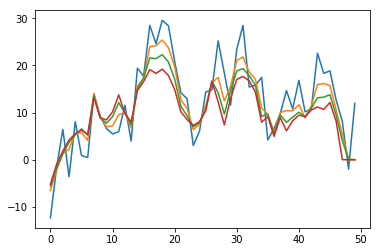

In [48]:
plt.plot(LIMfd_valid['x_forecast'][0,0,-50:])
plt.plot(LIMfd_valid['x_forecast'][1,0,-50:])
plt.plot(LIMfd_valid['x_forecast'][2,0,-50:])
plt.plot(LIMfd_valid['x_forecast'][3,0,-50:])

In [36]:
# compute errors in both the EOF space and full grid point space
err,err_gm = LIM_utils.LIM_forecast_error(LIMfd_valid,X[:,valid_inds],E,lags,fields,lat_2d)
err_eofs,err_gm_eofs = LIM_utils.LIM_forecast_error(LIMfd_valid,np.real(np.matmul(E,x_valid)),E,lags,fields,lat_2d)

lag =  0
lag =  1
lag =  2
lag =  3
lag =  4
lag =  5
lag =  6
lag =  7
lag =  8
lag =  9
lag =  10
lag =  11
lag =  12
lag =  0
lag =  1
lag =  2
lag =  3
lag =  4
lag =  5
lag =  6
lag =  7
lag =  8
lag =  9
lag =  10
lag =  11
lag =  12


In [262]:
# climo variance in both EOF space and full gridded fields for the two chosen variables
valid_gm_var_var1,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None][var1_inds,:],[nlat,nlon]),lat_2d[:,0])
valid_gm_var_var1_full,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_full[:,None][var1_inds,:],[nlat,nlon]),lat_2d[:,0])
if nvars>1:
    valid_gm_var_var2,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None][var2_inds,:],[nlat,nlon]),lat_2d[:,0])
    valid_gm_var_var2_full,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_full[:,None][var2_inds,:],[nlat,nlon]),lat_2d[:,0])


file root:  CCSM4_sic_error_eof_space


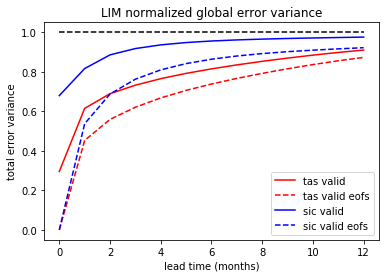

In [274]:
savefig = False
#savefig = True

plt.plot(lags,err_gm[var1ind,:]/valid_gm_var_var1_full,'r-',label=var1+' valid')
plt.plot(lags,err_gm_eofs[var1ind,:]/valid_gm_var_var1,'r--',label=var1+' valid eofs')
if nvars>1:
    plt.plot(lags,err_gm[var2ind,:]/valid_gm_var_var2_full,'b-',label=var2+' valid')
    plt.plot(lags,err_gm_eofs[var2ind,:]/valid_gm_var_var2,'b--',label=var2+' valid eofs')

plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized global error variance')

#froot = 'CCSM4_tas_sic_error_eof_space'
froot = 'CCSM4_sic_error_eof_space'
print('file root: ',froot)
if savefig: plt.savefig('./Figs_LIM/'+froot+'_ob_locations.png',dpi=300)


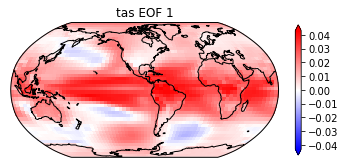

Text(0.5,1,'sic EOF 1')

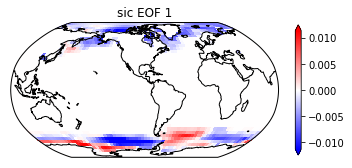

In [281]:
# plot the coupled EOFs
mode = 0
ax,cs = LIM_utils.plot_map_vector(E[var1_inds,mode],lat_2d,lon_2d)
ax.set_title(var1+' EOF '+str(mode+1))
plt.show()
ax,cs = LIM_utils.plot_map_vector(E[var2_inds,mode],lat_2d,lon_2d)
ax.set_title(var2+' EOF '+str(mode+1))
